In [1]:
import collections
import itertools
import nltk
import numpy as np
import matplotlib.pyplot as plt
import os
import random

#### ...train.txt 내용
1 Mary moved to the bathroom.<br>------------story
2 John went to the hallway.<br>--------------story
3 Where is Mary? (tab)bathroom(tab)1---------Question---An

 a='\t I\tlove you .....\n'
 a.strip()->'I \t love you'

In [3]:
def get_data(infile): #위의 글 한 라인씩 읽음
    stories, questions, answers = [], [], []
    story_text = []
    fin = open(infile, "r") 
    for line in fin:
        line = line.strip()                # strip() : 양쪽 끝에 있는 공백, \t, \n 제거
        lno, text = line.split(" ", 1)     # 맨 앞의 라인 번호 분리, 1을 안써주면 공백마다 분리시킴, 
                                           # lno=1, text는 Mary moved to the bathroom.로 배정
        if "\t" in text:                   # 세 번째 문장에는 \t가 두개 있음.
            question, answer, _ = text.split("\t")
            stories.append(story_text)     # 처음 두 문장
            questions.append(question)     # 세 번째 문장의 질문
            answers.append(answer)         # 세 번째 문장의 답변
            story_text = []
        else:
            story_text.append(text)        # 처음 두 문장이 하나의 리스트에 들어감
    fin.close()
    return stories, questions, answers

# get the data
data_train = get_data("qa1_single-supporting-fact_train.txt")
data_test = get_data("qa1_single-supporting-fact_test.txt")

print("Train observations:",len(data_train[0]),"Test observations:", len(data_test[0]))

Train observations: 10000 Test observations: 1000


첫 번째 에피소딕 스토리, 질문(Q), 답변(A) 확인

In [4]:
print("스토리 = ", data_train[0][0])
print("질  문 = ", data_train[1][0])
print("답  변 = ", data_train[2][0])

스토리 =  ['Mary moved to the bathroom.', 'John went to the hallway.']
질  문 =  Where is Mary? 
답  변 =  bathroom


#### Building Vocab dictionary from Train & Test data

In [8]:
dictnry = collections.Counter()
for stories, questions, answers in [data_train, data_test]:#[0]:story,[1]:question,[2]:answer
    for story in stories:
        for sent in story:
            for word in nltk.word_tokenize(sent):
                dictnry[word.lower()] += 1#사용빈도 count 작업
                
    for question in questions:
        for word in nltk.word_tokenize(question):
            dictnry[word.lower()] += 1
            
    for answer in answers:
        for word in nltk.word_tokenize(answer):
            dictnry[word.lower()] += 1

word2indx = {w:(i+1) for i,(w,_) in enumerate(dictnry.most_common())}#dictionary읽기, 가장 빈도가 높은 순으로 
#           숫자 붙여
                                                                #()안에는 개수 지정
word2indx["PAD"] = 0       #padding 인덱스 붙임
indx2word = {v:k for k,v in word2indx.items()}

vocab_size = len(word2indx)
print("vocabulary size:",len(word2indx))
print(word2indx)

#빈도 높은 순으로 정렬,22단어

vocabulary size: 22
{'to': 1, 'the': 2, '.': 3, 'where': 4, 'is': 5, '?': 6, 'went': 7, 'john': 8, 'sandra': 9, 'mary': 10, 'daniel': 11, 'bathroom': 12, 'office': 13, 'garden': 14, 'hallway': 15, 'kitchen': 16, 'bedroom': 17, 'journeyed': 18, 'travelled': 19, 'back': 20, 'moved': 21, 'PAD': 0}


#### compute max sequence length for each entity (제일 긴 문장기준-길이 맞춰주기-)

In [9]:
story_maxlen = 0
question_maxlen = 0

# 2 문장의 story를 합쳤을 때의 단어 개수 = 길이
for stories, questions, answers in [data_train, data_test]:
    for story in stories: # stories = ["   ", "  "]-->story 두 개씩 문장에 들어있던 것
        story_len = 0
        for sent in story:#위의 story의 sentence 하나 부르기
            swords = nltk.word_tokenize(sent)#swords=["John","went","to"...]->단어 개수
            story_len += len(swords)
        if story_len > story_maxlen:
            story_maxlen = story_len #story의 최대 길이 구하기위해 실행된 문장임.
            
            #위에 것 question 버전
    for question in questions:
        question_len = len(nltk.word_tokenize(question))
        if question_len > question_maxlen:
            question_maxlen = question_len
            
print ("Story maximum length:",story_maxlen,"Question maximum length:",question_maxlen)
#표준화 시키기 위해 각각 최대 길이를 찾아냄----->모든 스토리-14로 표준화

Story maximum length: 14 Question maximum length: 4


In [10]:
from keras.layers import Input
from keras.layers.core import Activation, Dense, Dropout, Permute
from keras.layers.embeddings import Embedding
from keras.layers.merge import add, concatenate, dot
from keras.layers.recurrent import LSTM
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils

#### Converting data into Vectorized form
Xstrain[0] = [0,0,8,21,1,2,12,3,9,7,1,2,13,3]   - 14개<br>
Xqtrain[0] = [4,5,8,6] - 4개<br>
Ytrain[0] = [0,0,0,0,...0,1,0,0,0,]   - 22개의 one-hot  
  
ex) Story=["John went to the garden.",  
           "Sandara went to the bathroom"]--Xstrain   
    Question=["$where is sandara?"]---------Xqtrain  
    Answer=["bathroom"]---------------------Ytrain

In [11]:
# list of list 연습
for story, question, answer in zip(stories, questions, answers):
    xs = [[word2indx[w.lower()] for w in nltk.word_tokenize(s)] for s in story]
    print(story)
    print(xs)
    xs = list(itertools.chain.from_iterable(xs))
    print(xs)
    break

['John travelled to the hallway.', 'Mary journeyed to the bathroom.']
[[8, 19, 1, 2, 15, 3], [10, 18, 1, 2, 12, 3]]
[8, 19, 1, 2, 15, 3, 10, 18, 1, 2, 12, 3]


In [12]:
def data_vectorization(data, word2indx, story_maxlen, question_maxlen):
    Xs, Xq, Y = [], [], []
    stories, questions, answers = data
    for story, question, answer in zip(stories, questions, answers):
        xs = [[word2indx[w.lower()] for w in nltk.word_tokenize(s)] for s in story]
        xs = list(itertools.chain.from_iterable(xs))   # 2개 스토리를 하나로 합친다
        xq = [word2indx[w.lower()] for w in nltk.word_tokenize(question)]
        Xs.append(xs)
        Xq.append(xq)
        Y.append(word2indx[answer.lower()])
        
    return pad_sequences(Xs, maxlen=story_maxlen),\
           pad_sequences(Xq, maxlen=question_maxlen),\
           np_utils.to_categorical(Y, num_classes=len(word2indx))

Xstrain, Xqtrain, Ytrain = data_vectorization(data_train, word2indx, story_maxlen, question_maxlen)
Xstest, Xqtest, Ytest = data_vectorization(data_test, word2indx, story_maxlen, question_maxlen)

print("Train story",Xstrain.shape,"Train question", Xqtrain.shape,"Train answer", Ytrain.shape)
print( "Test story",Xstest.shape, "Test question",Xqtest.shape, "Test answer",Ytest.shape)

Train story (10000, 14) Train question (10000, 4) Train answer (10000, 22)
Test story (1000, 14) Test question (1000, 4) Test answer (1000, 22)


In [13]:
Xstrain[0]

array([ 0,  0, 10, 21,  1,  2, 12,  3,  8,  7,  1,  2, 15,  3])

#### Model Parameters

In [14]:
EMBEDDING_SIZE = 128
LATENT_SIZE = 64
BATCH_SIZE = 64
NUM_EPOCHS = 40

# Inputs
story_input = Input(shape=(story_maxlen,))
question_input = Input(shape=(question_maxlen,))

# Story encoder embedding
story_encoder = Embedding(input_dim=vocab_size, output_dim=EMBEDDING_SIZE,
                         input_length=story_maxlen)(story_input)
story_encoder = Dropout(rate = 0.2)(story_encoder)

# Question encoder embedding
question_encoder = Embedding(input_dim=vocab_size,output_dim=EMBEDDING_SIZE,
                            input_length=question_maxlen)(question_input)
question_encoder = Dropout(rate = 0.3)(question_encoder)

# Match between story and question
match = dot([story_encoder, question_encoder], axes=[2,2])

# Encode story into vector space of question
story_encoder_c = Embedding(input_dim=vocab_size,output_dim=question_maxlen,
                           input_length=story_maxlen)(story_input)
story_encoder_c = Dropout(rate = 0.3)(story_encoder_c)

# Combine match and story vectors
response = add([match, story_encoder_c])
response = Permute((2, 1))(response)

# Combine response and question vectors to answers space
answer = concatenate([response, question_encoder], axis=-1)
answer = LSTM(LATENT_SIZE)(answer)
answer = Dropout(rate = 0.2)(answer)
answer = Dense(vocab_size)(answer)
output = Activation("softmax")(answer)

model = Model(inputs=[story_input, question_input], outputs=output)
model.compile(optimizer="adam", loss="categorical_crossentropy",metrics=["accuracy"])
print (model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 14)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 4)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 14, 128)      2816        input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embeddin

#### Model Training

In [15]:
history = model.fit([Xstrain, Xqtrain], [Ytrain], batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS, validation_data=([Xstest, Xqtest], [Ytest]))

Instructions for updating:
Use tf.cast instead.
Train on 10000 samples, validate on 1000 samples
Epoch 1/40
10000/10000 [==============================] - 5s 504us/step - loss: 2.0352 - acc: 0.1728 - val_loss: 1.7256 - val_acc: 0.2910
Epoch 2/40
10000/10000 [==============================] - 1s 132us/step - loss: 1.6734 - acc: 0.2757 - val_loss: 1.6406 - val_acc: 0.3610
Epoch 3/40
10000/10000 [==============================] - 1s 150us/step - loss: 1.5564 - acc: 0.4137 - val_loss: 1.4667 - val_acc: 0.5130
Epoch 4/40
10000/10000 [==============================] - 1s 145us/step - loss: 1.4028 - acc: 0.5132 - val_loss: 1.3703 - val_acc: 0.5260
Epoch 5/40
10000/10000 [==============================] - 1s 134us/step - loss: 1.3364 - acc: 0.5206 - val_loss: 1.3201 - val_acc: 0.5270
Epoch 6/40
10000/10000 [==============================] - 2s 157us/step - loss: 1.2953 - acc: 0.5160 - val_loss: 1.2974 - val_acc: 0.5220
Epoch 7/40
10000/10000 [==============================] - 1s 137us/step - l

#### plot accuracy and loss plot

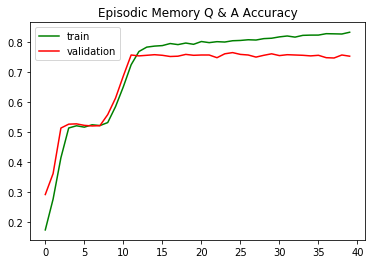

In [16]:
plt.title("Episodic Memory Q & A Accuracy")
plt.plot(history.history["acc"], color="g", label="train")
plt.plot(history.history["val_acc"], color="r", label="validation")
plt.legend(loc="best")
plt.show()
#train은 상승세여도 valid는 고정, 학습을 더 시켜봐도 정확도가 오를 것 같지는 않음

#### get predictions of labels

In [17]:
from sklearn.metrics import accuracy_score
ytest = np.argmax(Ytest, axis=1)
Ytest_ = model.predict([Xstest, Xqtest])
ytest_ = np.argmax(Ytest_, axis=1)
accuracy_score(ytest, ytest_)

0.753

#### Select Random questions and predict answers

In [18]:
NUM_DISPLAY = 10
   
for i in random.sample(range(Xstest.shape[0]),NUM_DISPLAY):
    story = " ".join([indx2word[x] for x in Xstest[i].tolist() if x != 0])
    question = " ".join([indx2word[x] for x in Xqtest[i].tolist()])
    label = indx2word[ytest[i]]
    prediction = indx2word[ytest_[i]]
    print(story, question, label, prediction)

sandra moved to the bathroom . daniel travelled to the bathroom . where is daniel ? bathroom bathroom
sandra journeyed to the hallway . mary went to the hallway . where is daniel ? office office
sandra travelled to the bathroom . john moved to the bedroom . where is daniel ? garden garden
mary moved to the hallway . mary moved to the bathroom . where is john ? hallway hallway
daniel journeyed to the bathroom . daniel travelled to the office . where is daniel ? office office
sandra went back to the bedroom . john moved to the garden . where is sandra ? bedroom bedroom
john travelled to the bathroom . mary moved to the kitchen . where is mary ? kitchen kitchen
john went back to the hallway . john moved to the office . where is john ? office office
mary travelled to the bedroom . john went back to the hallway . where is mary ? bedroom bedroom
john moved to the bedroom . john travelled to the kitchen . where is john ? kitchen kitchen


In [22]:
story

'john moved to the bedroom . john travelled to the kitchen .'

In [23]:
question

'where is john ?'

In [24]:
prediction

'kitchen'

의미론적 영역이 포함되지 않아도, 딥러닝만으로도 어느정도 구축은 가능하다.